<a href="https://colab.research.google.com/github/SonalSavaliya/Glaucoma-Detection-and-Classification/blob/master/Classification_of_Glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import 

In [1]:
# Importing the Keras libraries and packages
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix,roc_curve, auc
from scipy import interp
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import History 
history = History()

# Set path and Load Dataset

In [2]:
train_path = r"C:/Users/pong/Downloads/ai/dataset/Train"
test_path = r"C:/Users/pong/Downloads/ai/dataset/Test"

In [3]:
train_batches = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    batch_size=64,
    image_size=(224, 224),
    shuffle=True,
    seed = 0,
    validation_split=0.2,
    subset="training",
    label_mode="categorical" 
)

valid_batches = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    batch_size=64,
    image_size=(224, 224),
    shuffle=True,
    seed = 0,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical"
)

test_batches = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    batch_size=64,
    image_size=(224, 224),
    shuffle=True,
    seed = None,
    validation_split=None,
    subset=None,
    label_mode="categorical"
)

Found 5220 files belonging to 3 classes.
Using 4176 files for training.
Found 5220 files belonging to 3 classes.
Using 1044 files for validation.
Found 132 files belonging to 3 classes.


# Build Fine_Tuned Model with VGG-16

In [4]:
vgg16_model = VGG16()
#vgg16_model.summary()
#type(vgg16_model)

In [5]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [6]:
for layer in model.layers:
    layer.trainable = False

In [7]:
model.add(Dense(3, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

## Train Model

In [16]:
model.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
#model.fit_generator(train_batches, steps_per_epoch = 4, epochs = 10, validation_data = test_batches, validation_steps = 4, verbose = 2)

history = model.fit(train_batches, 
                    steps_per_epoch=len(train_batches), 
                    validation_data = valid_batches,
                    validation_steps=len(valid_batches),
                    epochs=30,
                    verbose=1)

Epoch 1/30
30/66 [============>.................] - ETA: 25s - loss: 0.6573 - accuracy: 0.7906

KeyboardInterrupt: 

# Save model 


In [12]:
import pickle
import os
path = r"C:/Users/pong/Downloads/ai"
os.chdir(path)
model.save("modelVGG16v2_l027a089.model")

INFO:tensorflow:Assets written to: modelVGG16v2_l027a089.model\assets


# Graph


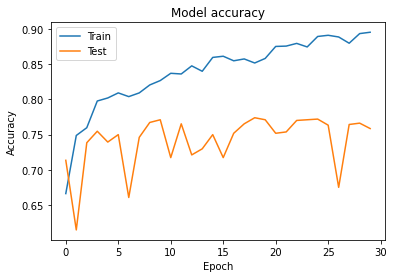

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
#plt.plot(history.history['acc'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

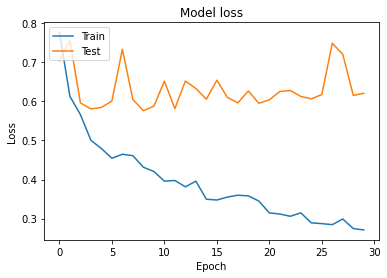

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## ROC curves

## Load model and predict

In [15]:
loadpath = r"C:/Users/pong/Downloads/ai/modelVGG16v2_l027a089.model/"
_model = keras.models.load_model(loadpath)

In [16]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                         title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
  
  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1) [:, np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Confusion Matrix without normalization")
  
  print(cm)
  
  thresh = cm.max() / 2.
  
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, cm[i,j],
            horizontalalignment ="center",
            color = "white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
  

In [17]:
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None):
  if type(ims[0]) is np.ndarray:
    ims = np.array(ims).astype(np.uint8)
    if(ims.shape[-1] != 3):
      ims = ims.transpose ((0,2,3,1))
  f = plt.figure(figsize = figsize)
  cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows +1
  for i in range(len(ims)):
    sp = f.add_subplot (rows, cols, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize =10)
    plt.imshow(ims[i], interpolation=None if interp else 'none')
    

In [18]:
new_test_path = r"C:/Users/pong/Downloads/ai/dataset/NewTest/"
test_batches_fine = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes =['Glaucoma','Normal','Other'], batch_size=50)
#batch_size=50
#classes =['Mild_ROI','Moderate_ROI','Severe_ROI']

Found 150 images belonging to 3 classes.


In [19]:
test_imgs, test_labels = next(test_batches_fine)


C:\Users\pong\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


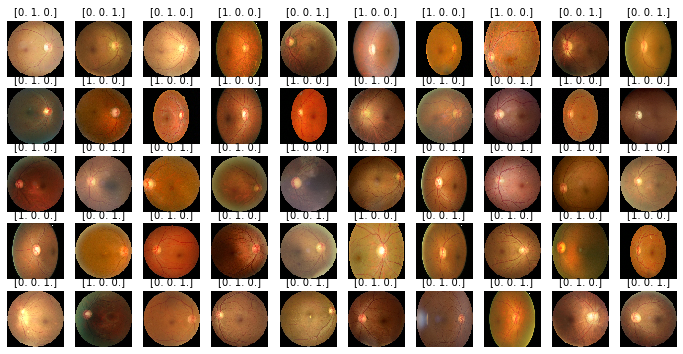

In [20]:
x_labels = test_labels.argmax(axis=1)
plots(test_imgs, titles=test_labels)

In [21]:
#test_labels = test_labels[:,0]
x_labels

array([1, 2, 1, 0, 2, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 2,
       2, 1, 0, 1, 2, 2, 1, 1, 0, 2, 1, 1, 2, 0, 2, 1, 1, 0, 2, 0, 2, 1,
       2, 1, 1, 2, 1, 2], dtype=int64)

In [22]:
predictions = _model.predict(test_batches_fine, steps=1, verbose=0)

In [23]:
y_labels = predictions.argmax(axis=1)
y_labels
#np.round(predictions[:,0])

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 2], dtype=int64)

In [24]:
cm = confusion_matrix(x_labels, y_labels)

In [25]:
cm_plot_labels = ['Glaucoma','Normal','Other']

Confusion Matrix without normalization
[[11  4  0]
 [ 0 17  1]
 [ 0 10  7]]


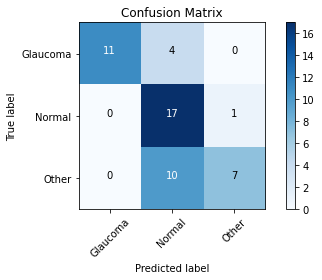

In [26]:
plot_confusion_matrix(cm, cm_plot_labels, title ='Confusion Matrix')